In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

# Ignore all warnings
warnings.filterwarnings("ignore")



<h2>
Process the Metadata

In [2]:
path = '/Users/wenyuanchen/Desktop/IBM/IBM_Tumor_Project/Data/autoPETmeta.csv'
raw_meta_df = pd.read_csv(path)
raw_meta_df.fillna('unknown', inplace=True)
raw_meta_df[['patient_id','study_id']] = raw_meta_df['study_location'].str.rsplit('/', n=2, expand=True)[[0,1]]
raw_meta_df['patient_id'] = raw_meta_df['patient_id'].str.split('/').str[-1]

def get_diagnosis(raw_meta_df = raw_meta_df):
    raw_df = raw_meta_df.copy()
    diagnosis_dict = {(row['patient_id'], row['study_id']): row['diagnosis'] for index, row in raw_df.iterrows()}
    return diagnosis_dict

def read_diagnosis_sample_patient_id(raw_meta_df = raw_meta_df,diagnosis = "NEGATIVE"):
    raw_df = raw_meta_df.copy()

    diagnosis_id_lst = raw_df[raw_df['diagnosis'] == diagnosis]['patient_id']
    diagnosis_study_lst = raw_df[raw_df['diagnosis'] == diagnosis]['study_id']
    return diagnosis_id_lst, diagnosis_study_lst


In [265]:
patient_study_counts = raw_meta_df.groupby('patient_id')['study_id'].nunique()
patients_with_multiple_studies = patient_study_counts[patient_study_counts > 1]

# The length of this filtered series gives us the number of Patient IDs with more than 1 unique Study ID
number_of_patients_more_than_1_study = len(patients_with_multiple_studies)
number_of_patients_more_than_1_study
print(f'There are {number_of_patients_more_than_1_study} patients with more than 1 study.')

There are 81 patients with more than 1 study.


In [266]:
# Find patients with negative diagnosis
negative_patients = set(raw_meta_df[raw_meta_df['diagnosis'] == 'NEGATIVE']['patient_id'])

# Find patients with positive diagnosis
positive_patients = set(raw_meta_df[raw_meta_df['diagnosis'] != 'NEGATIVE']['patient_id'])

# Find patients that are in both negative diagnosis and other positive diagnosis
cross_diagnosis_patients = negative_patients.intersection(positive_patients)

cross_diagnosis_patients
print(f"Number of patients that have more than 1 diagnosis: {len(cross_diagnosis_patients)}")

Number of patients that have more than 1 diagnosis: 30


In [5]:
diagnosis_dict = get_diagnosis(raw_meta_df = raw_meta_df)

In [6]:
negative_id_lst, negative_study_lst = read_diagnosis_sample_patient_id()

<h2>
Process the generated csv and EDA

In [7]:
path = '../all_patients_final_results_with_26_new_connected_components.csv'
# path = '../all_patients_results.csv'
raw_df = pd.read_csv(path)
print(f'raw_df shape: {raw_df.shape}')
raw_df.groupby(['Patient ID', 'Study ID']).size()
num_unique_patients = raw_df.groupby(['Patient ID']).size()
assert num_unique_patients.shape[0] == 900

num_unique_studies = raw_df.groupby(['Patient ID', 'Study ID']).size()
assert num_unique_studies.shape[0] == 1014

# Create a new column called 'Diagnosis' in the raw_df
tuples = list(zip(raw_df['Patient ID'], raw_df['Study ID']))
# Now map these tuples to their corresponding diagnosis using the diagnosis_dict
raw_df['Diagnosis'] = pd.Series(tuples).map(diagnosis_dict)


raw_df shape: (9133, 9)


In [9]:
remove_negative_sample_df = raw_df[raw_df['Diagnosis'] != 'NEGATIVE']
remove_negative_sample_df

,Patient ID,Study ID,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max,Diagnosis
0,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,1,103,1.2814,1.3476,5.2787,2.0571,16.1041,MELANOMA
1,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,2,59,0.7340,1.1192,4.7366,2.0748,12.3759,MELANOMA
2,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,3,41,0.5101,0.9913,3.2053,2.0643,5.9694,MELANOMA
3,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,4,280,3.4835,1.8808,4.9858,2.0629,15.4478,MELANOMA
4,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,5,816,10.1519,2.6865,7.3036,2.0607,19.6536,MELANOMA
...,...,...,...,...,...,...,...,...,...,...
9126,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,85,123,1.5302,1.4297,3.6867,2.0710,7.7638,LYMPHOMA
9127,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,86,85,1.0575,1.2640,3.6395,2.0594,9.8709,LYMPHOMA
9128,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,87,100,1.2441,1.3344,2.8568,2.0629,5.6163,LYMPHOMA
9129,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,88,75,0.9331,1.2124,3.3243,2.0933,5.3749,LYMPHOMA


In [245]:
raw_df.loc[raw_df['Patient ID'].isin(cross_diagnosis_patients), ['Patient ID', 'Study ID', 'Diagnosis']].drop_duplicates()


,Patient ID,Study ID,Diagnosis
53,PETCT_05808cf24e,03-18-2006-NA-PET-CT Ganzkoerper primaer mit ...,NEGATIVE
54,PETCT_05808cf24e,07-29-1999-NA-PET-CT Ganzkoerper nativ-42289,LYMPHOMA
339,PETCT_0fa313309d,04-23-2005-NA-Unspecified CT-29055,LYMPHOMA
342,PETCT_0fa313309d,10-03-2005-NA-PET-CT Ganzkoerper primaer mit ...,NEGATIVE
1667,PETCT_1956667fce,02-10-2006-NA-PET-CT Ganzkoerper primaer mit ...,NEGATIVE
...,...,...,...
9038,PETCT_fde79b6aa9,02-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,NEGATIVE
9039,PETCT_fde79b6aa9,05-09-2005-NA-PET-CT Ganzkoerper primaer mit ...,MELANOMA
9040,PETCT_fde79b6aa9,08-16-2003-NA-PET-CT Ganzkoerper primaer mit ...,NEGATIVE
9041,PETCT_fe705ea1cc,04-27-2003-NA-Unspecified CT ABDOMEN-47025,NEGATIVE


In [215]:
# tumor_less_than_0_6_in_diameter_df = remove_negative_sample_df[(remove_negative_sample_df['In Diameter(cm)']< 0.6) & (remove_negative_sample_df['SUV Max'] < 2.5)]
# filtered_non_clinical_important_tumor_df = remove_negative_sample_df[(remove_negative_sample_df['In Diameter(cm)']> 0.6) & (remove_negative_sample_df['SUV Max'] > 2.5)]
tumor_less_than_0_6_in_diameter_df = remove_negative_sample_df[remove_negative_sample_df['In Diameter(cm)']< 0.6]
suspicious_small_tumor_df = tumor_less_than_0_6_in_diameter_df[tumor_less_than_0_6_in_diameter_df['SUV Max'] > 2.5]
filtered_non_clinical_important_tumor_df = remove_negative_sample_df[remove_negative_sample_df['In Diameter(cm)']> 0.6]
filtered_non_clinical_important_tumor_df

,Patient ID,Study ID,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max,Diagnosis
0,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,1,103,1.2814,1.3476,5.2787,2.0571,16.1041,MELANOMA
1,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,2,59,0.7340,1.1192,4.7366,2.0748,12.3759,MELANOMA
2,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,3,41,0.5101,0.9913,3.2053,2.0643,5.9694,MELANOMA
3,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,4,280,3.4835,1.8808,4.9858,2.0629,15.4478,MELANOMA
4,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,5,816,10.1519,2.6865,7.3036,2.0607,19.6536,MELANOMA
...,...,...,...,...,...,...,...,...,...,...
9126,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,85,123,1.5302,1.4297,3.6867,2.0710,7.7638,LYMPHOMA
9127,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,86,85,1.0575,1.2640,3.6395,2.0594,9.8709,LYMPHOMA
9128,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,87,100,1.2441,1.3344,2.8568,2.0629,5.6163,LYMPHOMA
9129,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,88,75,0.9331,1.2124,3.3243,2.0933,5.3749,LYMPHOMA


In [230]:
filtered_cross_diag_patient_df = filtered_non_clinical_important_tumor_df[filtered_non_clinical_important_tumor_df['Patient ID'].isin(cross_diagnosis_patients)]

In [213]:
tumor_less_than_0_6_in_diameter_df.describe()

,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max
count,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000
mean,112.928380,3.231593,0.040191,0.398180,3.230737,3.082434,3.416063
std,193.818887,2.473147,0.030780,0.105004,0.987880,0.930825,1.126204
min,1.000000,1.000000,0.012400,0.287500,1.037100,0.844400,1.037500
25%,11.000000,1.000000,0.012400,0.287500,2.266550,2.158700,2.390550
50%,33.500000,2.000000,0.024900,0.362200,3.260700,3.150800,3.335900
75%,103.000000,5.000000,0.062200,0.491600,3.697000,3.416000,4.046650
max,1045.000000,9.000000,0.112000,0.598000,6.974700,6.974700,9.158200


<h3>
There are in total of 1494 tumor being removed using cut off = 0.6cm/6mm. 

In [214]:
filtered_non_clinical_important_tumor_df.describe()

,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max
count,7126.000000,7126.000000,7126.000000,7126.000000,7126.000000,7126.000000,7126.000000
mean,91.608336,1242.223267,15.454526,1.871176,4.835320,2.386848,13.398871
std,196.754906,6217.435659,77.351248,1.484885,2.430625,1.027827,12.880518
min,1.000000,10.000000,0.124400,0.619400,0.988200,0.094800,1.308200
25%,6.000000,45.250000,0.562925,1.024475,3.177325,1.551525,5.931325
50%,20.000000,124.000000,1.542700,1.433600,4.305550,2.138100,9.155400
75%,63.000000,373.000000,4.640500,2.069500,5.689725,3.129275,15.822075
max,1046.000000,172388.000000,2144.682700,16.000100,31.063800,6.105400,347.401500


In [287]:
def plot_level_(bins, labels, feature, df = filtered_non_clinical_important_tumor_df, hue = False, diagnosis_col = 'Diagnosis', in_place = False):
    if in_place:
        filtered_non_clinical_important_tumor_df = df
    else:
        filtered_non_clinical_important_tumor_df = df.copy()
    
    filtered_non_clinical_important_tumor_df[feature + ' Level'] = pd.cut(
    filtered_non_clinical_important_tumor_df[feature], 
    bins=bins, 
    labels=labels, 
    include_lowest=True
)
    if hue:
        # Create a cross-tabulation of diagnosis by feature levels
        diagnosis_by_level = pd.crosstab(
            filtered_non_clinical_important_tumor_df[feature + ' Level'], 
            filtered_non_clinical_important_tumor_df[diagnosis_col]
        )

        # Plot a stacked bar chart
        plt.figure(figsize=(10, 6))
        diagnosis_by_level.plot(kind='bar', stacked=True)

        plt.title('Frequency of Tumors by ' + feature + ' Level and Diagnosis', fontsize=16)
        plt.xlabel(feature + ' Level', fontsize=16)
        plt.ylabel('Frequency', fontsize=16)
        plt.xticks(rotation=0, fontsize=14)  # Rotate for better label readability
        plt.yticks(fontsize=14)
        plt.legend(title=diagnosis_col)
        plt.tight_layout()  # Adjust layout to prevent label cut-offs
        plt.show()
    else:
          # Count the frequency of each level without hue categorization
        plt.figure(figsize=(10, 6))
        level_counts = filtered_non_clinical_important_tumor_df[feature + ' Level'].value_counts().reindex(labels)
        level_counts.plot(kind='bar', color='skyblue')
        plt.title('Frequency of Tumors by ' + feature + ' Level', fontsize=16)
        plt.xlabel(feature + ' Level', fontsize=16)
        plt.ylabel('Frequency', fontsize=16)
        plt.xticks(rotation=0, fontsize = 16) 
        plt.yticks(fontsize = 16)
        plt.show()

<Figure size 1000x600 with 0 Axes>

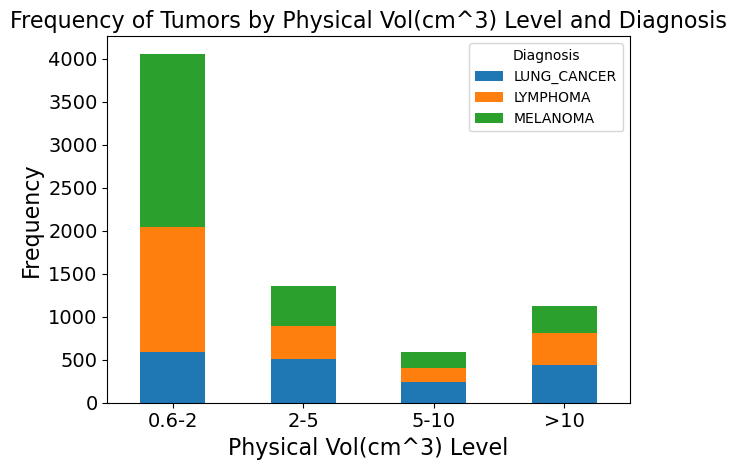

In [288]:
# Define the bins edges
bins = [0, 2, 5, 10, float('inf')]

# Define the labels for the bins
labels = ['0.6-2', '2-5', '5-10', '>10']

plot_level_(bins, labels, 'Physical Vol(cm^3)', hue=True, in_place = True)

<Figure size 1000x600 with 0 Axes>

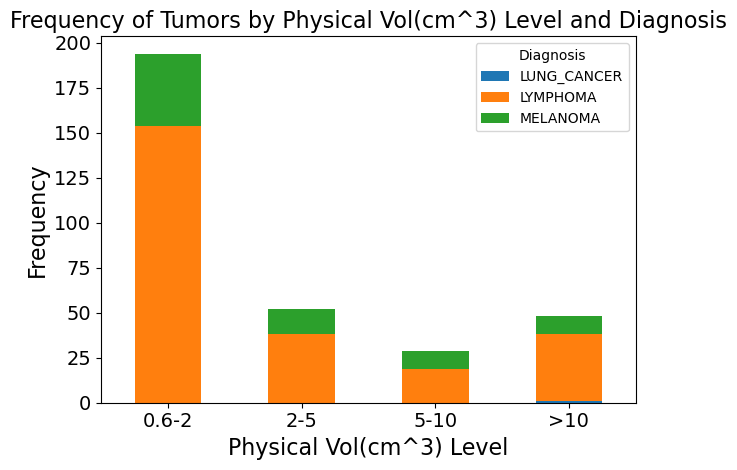

In [231]:
# Define the bins edges
bins = [0, 2, 5, 10, float('inf')]

# Define the labels for the bins
labels = ['0.6-2', '2-5', '5-10', '>10']

plot_level_(bins, labels, 'Physical Vol(cm^3)', df = filtered_cross_diag_patient_df, hue=True)

<Figure size 1000x600 with 0 Axes>

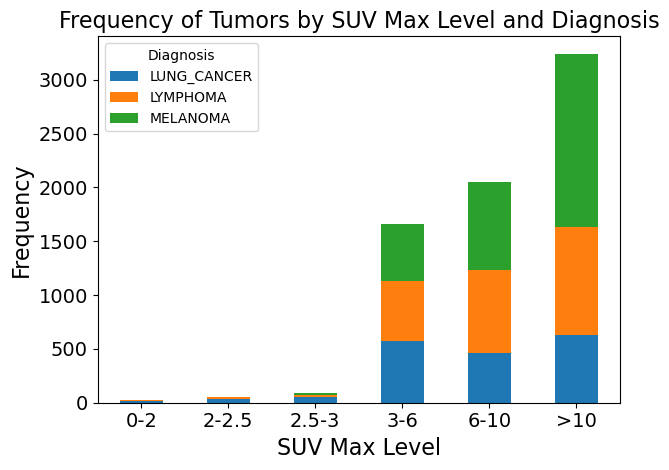

In [289]:
bins = [0, 2, 2.5, 3, 6, 10, float('inf')]
# Define the labels for the bins
labels = ['0-2', '2-2.5', '2.5-3', '3-6', '6-10', '>10']
plot_level_(bins, labels, 'SUV Max', hue = True, in_place = True)


<Figure size 1000x600 with 0 Axes>

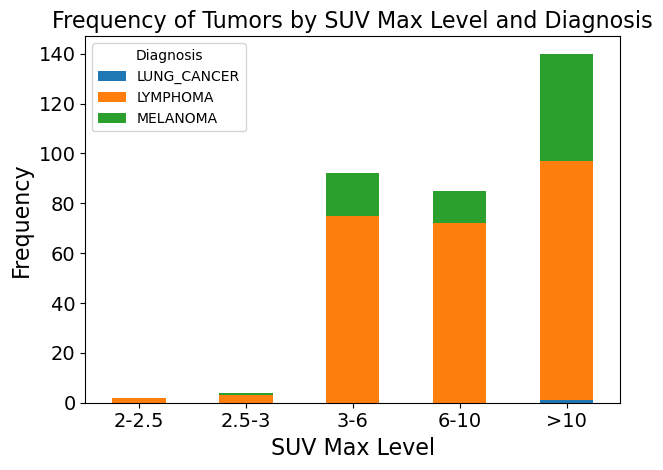

In [232]:
bins = [0, 2, 2.5, 3, 6, 10, float('inf')]
# Define the labels for the bins
labels = ['0-2', '2-2.5', '2.5-3', '3-6', '6-10', '>10']
plot_level_(bins, labels, 'SUV Max', df = filtered_cross_diag_patient_df, hue = True)


In [233]:
def plot_hist(feature, df = filtered_non_clinical_important_tumor_df):
    plt.figure(figsize=(10, 6))
    plt.hist(df[feature], bins=30, alpha=0.7, color='blue')
    plt.title('Frequency vs ' + feature, fontsize=16)
    plt.xlabel(feature, fontsize=16)
    plt.ylabel('Frequency', fontsize=16)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.grid(True)
    plt.show()
    

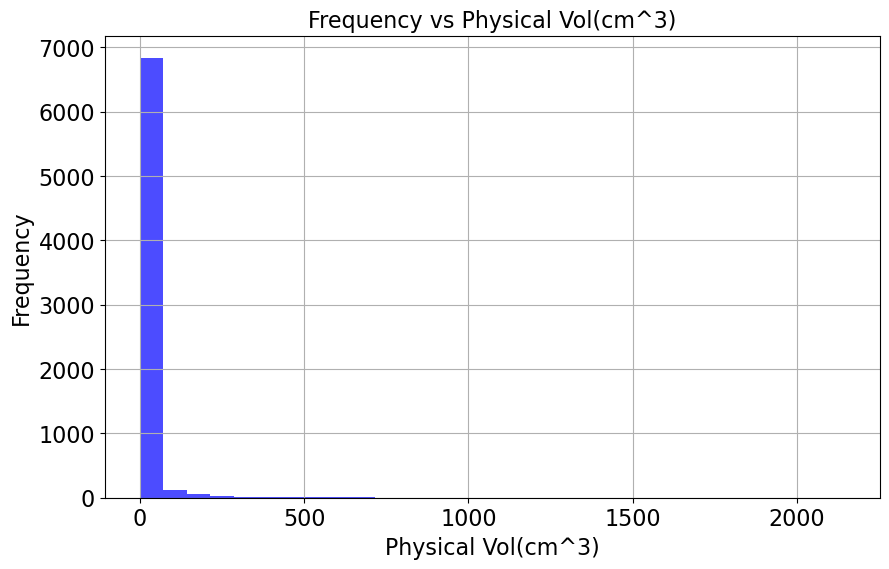

In [234]:
plot_hist('Physical Vol(cm^3)')

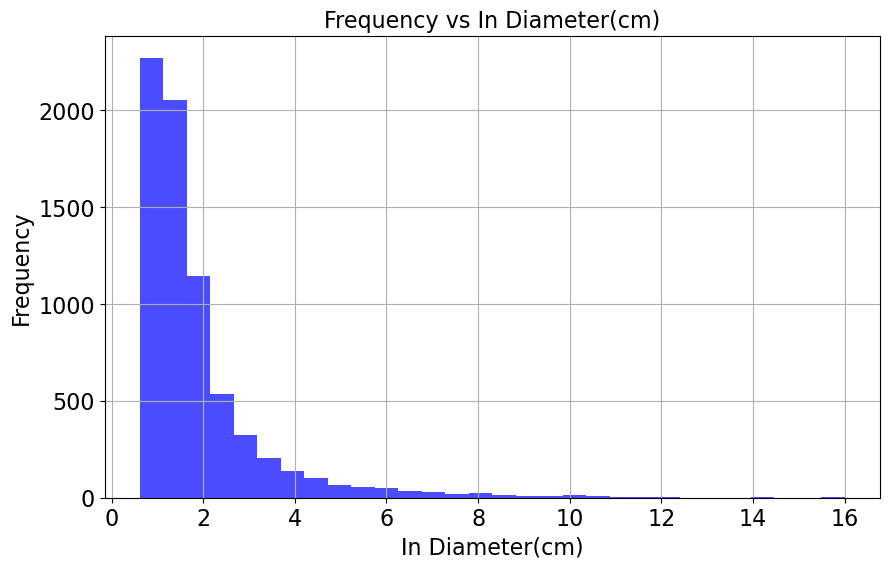

In [235]:
plot_hist('In Diameter(cm)')

In [122]:
def plot_tumor_count_per_study(df, bins=50, xlim=None,ylim=None):
    # tumor_per_study = filtered_non_clinical_important_tumor_df.groupby(['Patient ID', 'Study ID']).size().value_counts()
    plt.figure(figsize=(10, 6))
    plt.hist(df.groupby(['Patient ID', 'Study ID']).size().values, bins=bins, alpha=0.7, color='blue')
    plt.title('Frequency vs Tumor Count per Study', fontsize=16)
    plt.xlabel('Tumor Count per Study', fontsize=16)
    plt.ylabel('Frequency', fontsize=16) 
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14) 
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.grid(True)


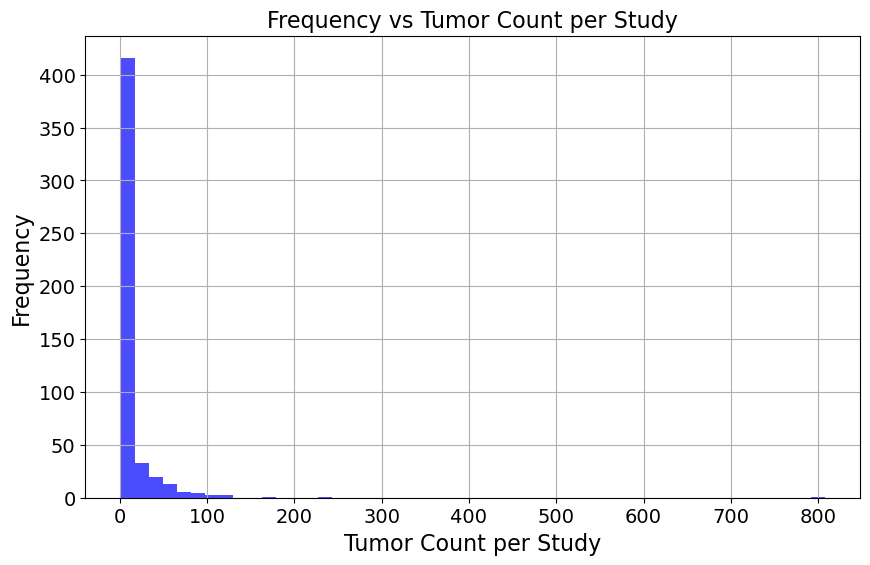

In [124]:
plot_tumor_count_per_study(filtered_non_clinical_important_tumor_df)

<h2>
We can see there is one outlier center around 800 for tumor count per study and the outlier ID is : 'PETCT_1285b86bea'

In [52]:
filtered_non_clinical_important_tumor_df[filtered_non_clinical_important_tumor_df['Patient ID'] == 'PETCT_1285b86bea']

,Patient ID,Study ID,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max,Diagnosis,Physical Vol(cm^3) Level,SUV Max Level
373,PETCT_1285b86bea,02-24-2006-NA-PET-CT Ganzkoerper primaer mit ...,1,108,1.3436,1.3691,11.3470,3.2805,55.4408,MELANOMA,0.6-2,>10
374,PETCT_1285b86bea,02-24-2006-NA-PET-CT Ganzkoerper primaer mit ...,2,24,0.2986,0.8293,9.8334,3.6970,29.4463,MELANOMA,0.6-2,>10
375,PETCT_1285b86bea,02-24-2006-NA-PET-CT Ganzkoerper primaer mit ...,3,24,0.2986,0.8293,5.7868,3.2736,12.9158,MELANOMA,0.6-2,>10
376,PETCT_1285b86bea,02-24-2006-NA-PET-CT Ganzkoerper primaer mit ...,4,1170,14.5560,3.0293,18.7686,3.2800,82.8191,MELANOMA,>10,>10
377,PETCT_1285b86bea,02-24-2006-NA-PET-CT Ganzkoerper primaer mit ...,5,97,1.2068,1.3209,11.1360,3.3386,44.4185,MELANOMA,0.6-2,>10
...,...,...,...,...,...,...,...,...,...,...,...,...
1412,PETCT_1285b86bea,02-24-2006-NA-PET-CT Ganzkoerper primaer mit ...,1040,16,0.1991,0.7244,4.0380,2.6605,6.3878,MELANOMA,0.6-2,6-10
1413,PETCT_1285b86bea,02-24-2006-NA-PET-CT Ganzkoerper primaer mit ...,1041,18,0.2239,0.7534,4.6608,2.6889,11.1557,MELANOMA,0.6-2,>10
1414,PETCT_1285b86bea,02-24-2006-NA-PET-CT Ganzkoerper primaer mit ...,1042,46,0.5723,1.0301,5.0005,2.7512,12.3460,MELANOMA,0.6-2,>10
1415,PETCT_1285b86bea,02-24-2006-NA-PET-CT Ganzkoerper primaer mit ...,1043,14,0.1742,0.6929,3.3359,2.6720,4.3857,MELANOMA,0.6-2,3-6


<h3> Drop the outlier

In [62]:
drop_outlier_df = filtered_non_clinical_important_tumor_df[filtered_non_clinical_important_tumor_df['Patient ID'] != 'PETCT_1285b86bea']

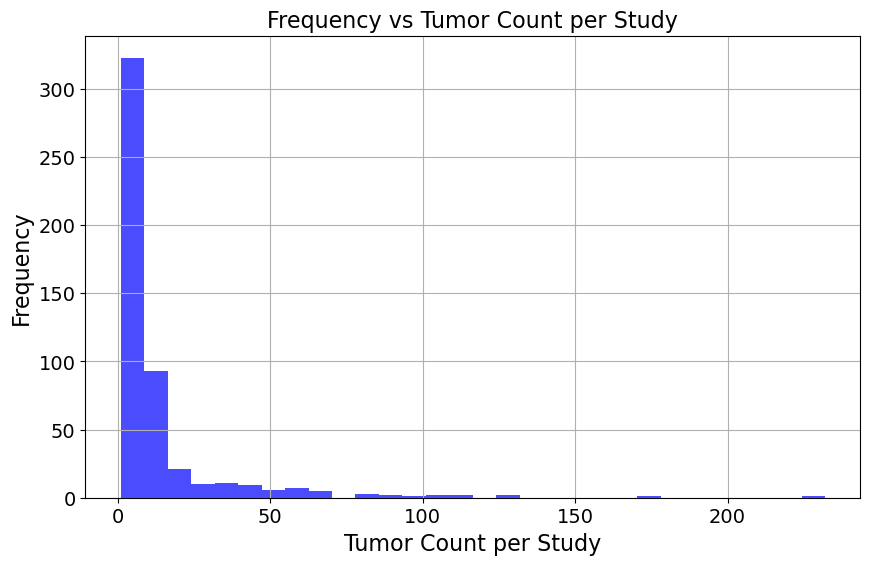

In [106]:
plot_tumor_count_per_study(drop_outlier_df)

In [274]:
def scatter_plot(feature1, feature2, df, xlim=None, ylim=None):
    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(df[feature1], 
                df[feature2],
                c=df['Diagnosis'].astype('category').cat.codes,  # categorize color by diagnosis
                cmap='viridis',
                alpha=0.5)

    # Add title and labels
    plt.title(feature1 + ' vs ' + feature2)
    plt.xlabel(feature1)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
#     plt.xlim(0, 200)
#     plt.ylim(0, 100)
    plt.ylabel(feature2)
    unique_labels = df['Diagnosis'].unique()
    handles = [plt.Line2D([], [], marker="o", linestyle="", color=scatter.cmap(scatter.norm(i)), label=label)
            for i, label in enumerate(unique_labels)]
    plt.legend(handles=handles, title='Diagnosis')

    # Show the plot
    plt.show()

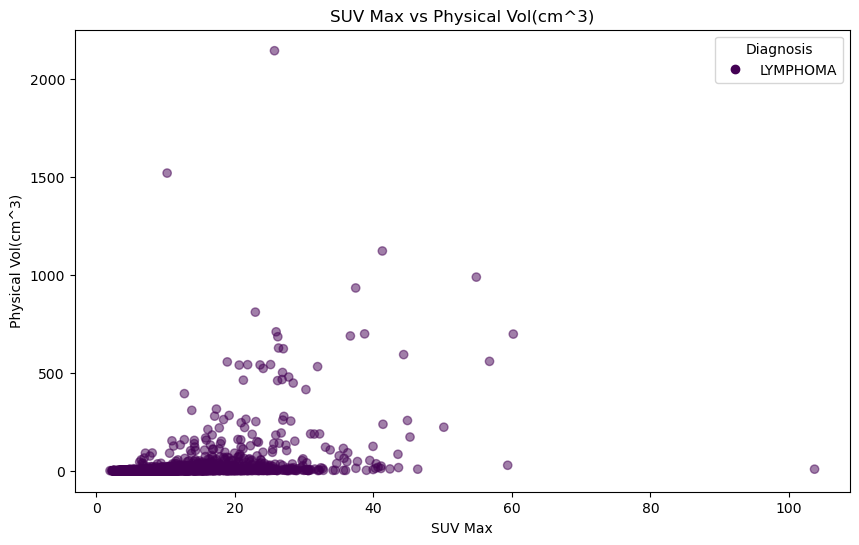

In [177]:
scatter_plot('SUV Max','Physical Vol(cm^3)', filtered_non_clinical_important_tumor_df[filtered_non_clinical_important_tumor_df['Diagnosis'] ==  'LYMPHOMA'])

In [202]:
filename ="study tumor being filtered.npy"
np.save(filename ,tumor_less_than_0_6_in_diameter_df[['Patient ID', "Study ID"]].drop_duplicates().values, allow_pickle=True)

In [150]:
tumor_less_than_0_6_in_diameter_df[tumor_less_than_0_6_in_diameter_df['Patient ID'] == 'PETCT_5d553bf6b4']

,Patient ID,Study ID,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max,Diagnosis
3677,PETCT_5d553bf6b4,09-16-2001-NA-PET-CT Ganzkoerper primaer mit ...,8,1,0.0124,0.2875,1.6284,1.6284,1.6284,LUNG_CANCER
3679,PETCT_5d553bf6b4,09-16-2001-NA-PET-CT Ganzkoerper primaer mit ...,10,6,0.0746,0.5224,1.6160,1.4991,1.7073,LUNG_CANCER


In [186]:
filtered_non_clinical_important_tumor_df[filtered_non_clinical_important_tumor_df['Patient ID'] == 'PETCT_fe705ea1cc']

,Patient ID,Study ID,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max,Diagnosis,Physical Vol(cm^3) Level,SUV Max Level
9043,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,2,1330,16.5466,3.1616,4.3937,2.0579,13.0667,LYMPHOMA,>10,>10
9044,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,3,41,0.5101,0.9913,3.5326,2.0655,7.3376,LYMPHOMA,0.6-2,6-10
9047,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,6,250,3.1103,1.8111,3.6185,2.0585,8.0881,LYMPHOMA,2-5,6-10
9048,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,7,377,4.6903,2.0768,3.5857,2.0607,7.2643,LYMPHOMA,2-5,6-10
9050,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,9,122,1.5178,1.4258,3.0861,2.0732,5.5115,LYMPHOMA,0.6-2,3-6
...,...,...,...,...,...,...,...,...,...,...,...,...
9126,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,85,123,1.5302,1.4297,3.6867,2.0710,7.7638,LYMPHOMA,0.6-2,6-10
9127,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,86,85,1.0575,1.2640,3.6395,2.0594,9.8709,LYMPHOMA,0.6-2,6-10
9128,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,87,100,1.2441,1.3344,2.8568,2.0629,5.6163,LYMPHOMA,0.6-2,3-6
9129,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,88,75,0.9331,1.2124,3.3243,2.0933,5.3749,LYMPHOMA,0.6-2,3-6


<Figure size 1000x600 with 0 Axes>

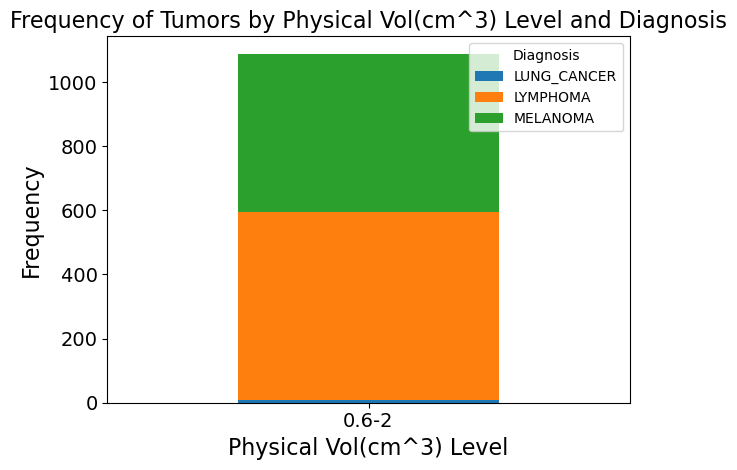

In [216]:
bins = [0, 2, 5, 10, float('inf')]

# Define the labels for the bins
labels = ['0.6-2', '2-5', '5-10', '>10']

plot_level_(bins, labels, 'Physical Vol(cm^3)',df = suspicious_small_tumor_df, hue=True)

<Figure size 1000x600 with 0 Axes>

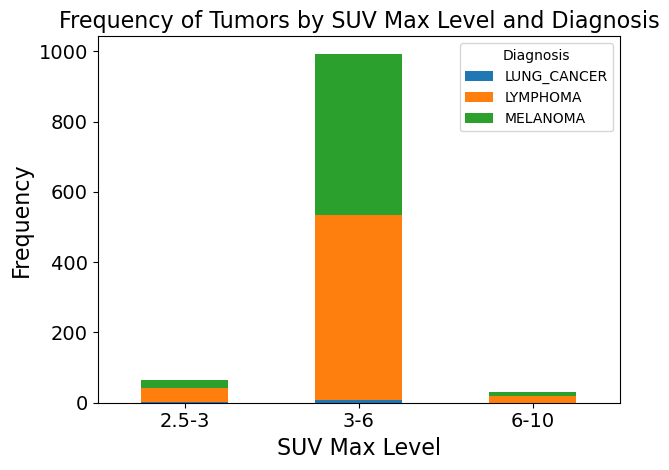

In [217]:
bins = [0, 2, 2.5, 3, 6, 10, float('inf')]
# Define the labels for the bins
labels = ['0-2', '2-2.5', '2.5-3', '3-6', '6-10', '>10']
plot_level_(bins, labels, 'SUV Max',df = suspicious_small_tumor_df, hue = True)


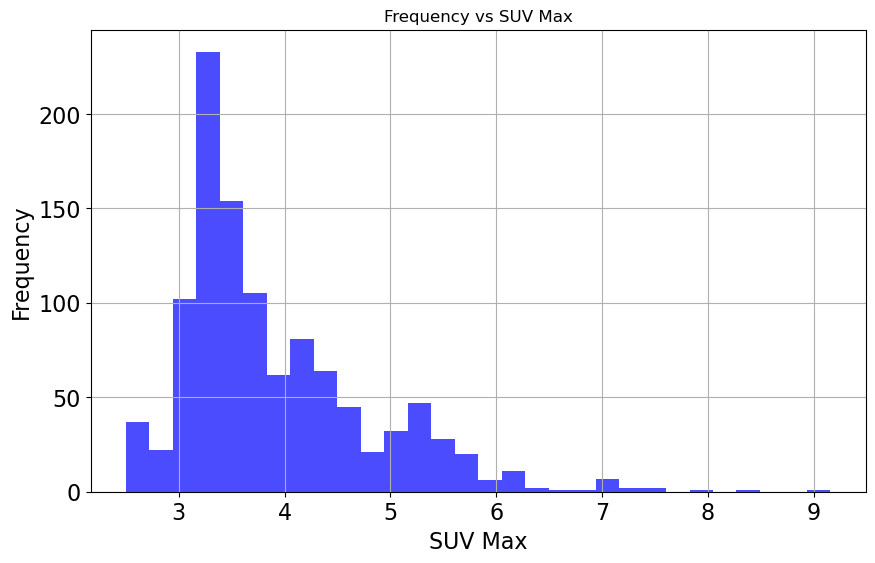

In [224]:
plot_hist('SUV Max', df = suspicious_small_tumor_df)

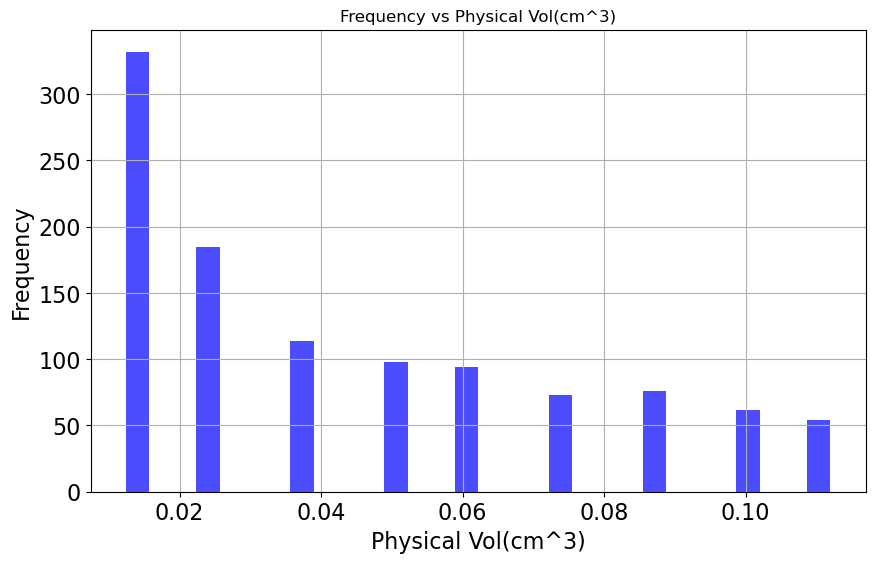

In [223]:
plot_hist('Physical Vol(cm^3)', df = suspicious_small_tumor_df)

<Figure size 1000x600 with 0 Axes>

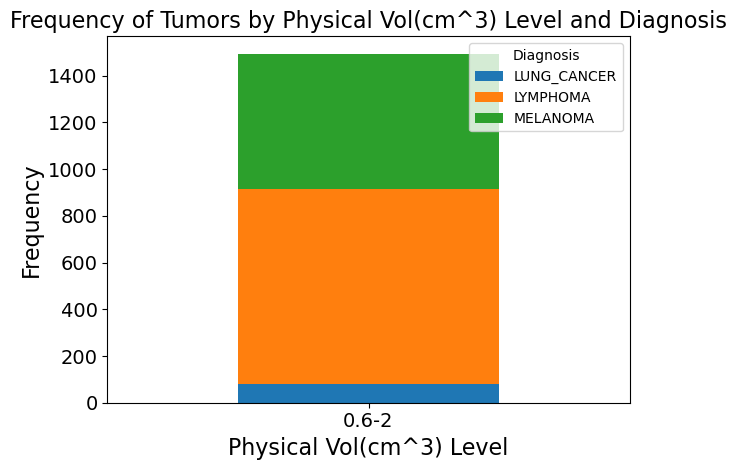

In [204]:
bins = [0, 2, 5, 10, float('inf')]

# Define the labels for the bins
labels = ['0.6-2', '2-5', '5-10', '>10']

plot_level_(bins, labels, 'Physical Vol(cm^3)',df = tumor_less_than_0_6_in_diameter_df, hue=True)

<Figure size 1000x600 with 0 Axes>

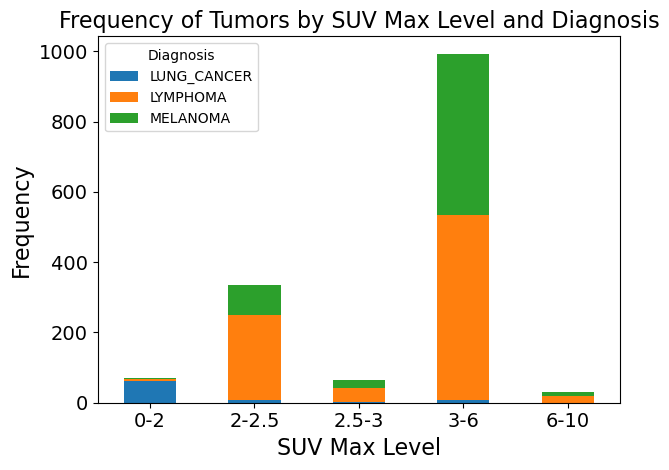

In [205]:
bins = [0, 2, 2.5, 3, 6, 10, float('inf')]
# Define the labels for the bins
labels = ['0-2', '2-2.5', '2.5-3', '3-6', '6-10', '>10']
plot_level_(bins, labels, 'SUV Max',df = tumor_less_than_0_6_in_diameter_df, hue = True)


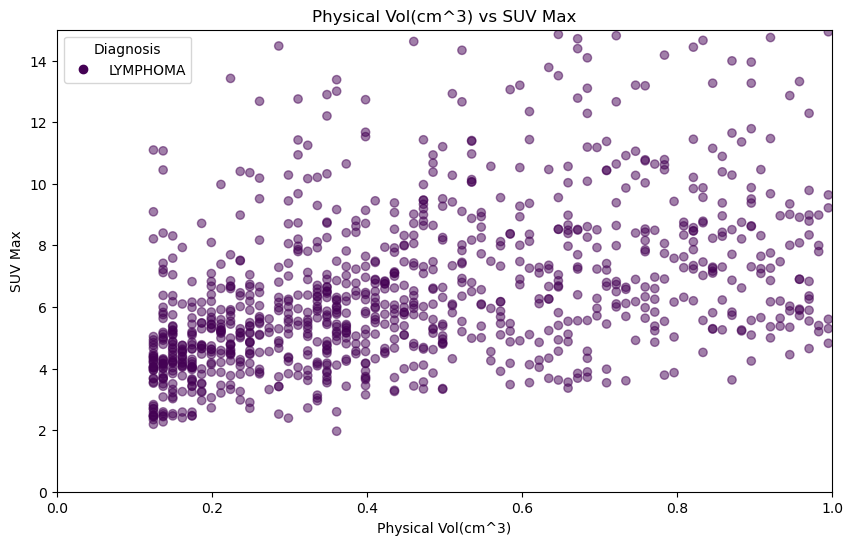

In [280]:
scatter_plot('Physical Vol(cm^3)','SUV Max',drop_outlier_df[drop_outlier_df['Diagnosis'] ==  'LYMPHOMA'], xlim=(0, 1), ylim=(0, 15))

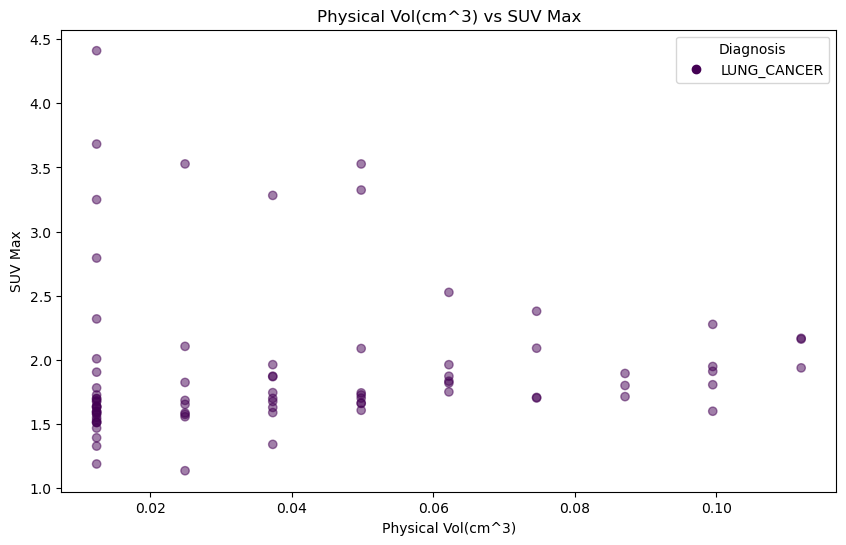

In [182]:
scatter_plot('Physical Vol(cm^3)','SUV Max', tumor_less_than_0_6_in_diameter_df[tumor_less_than_0_6_in_diameter_df['Diagnosis'] ==  'LUNG_CANCER'])

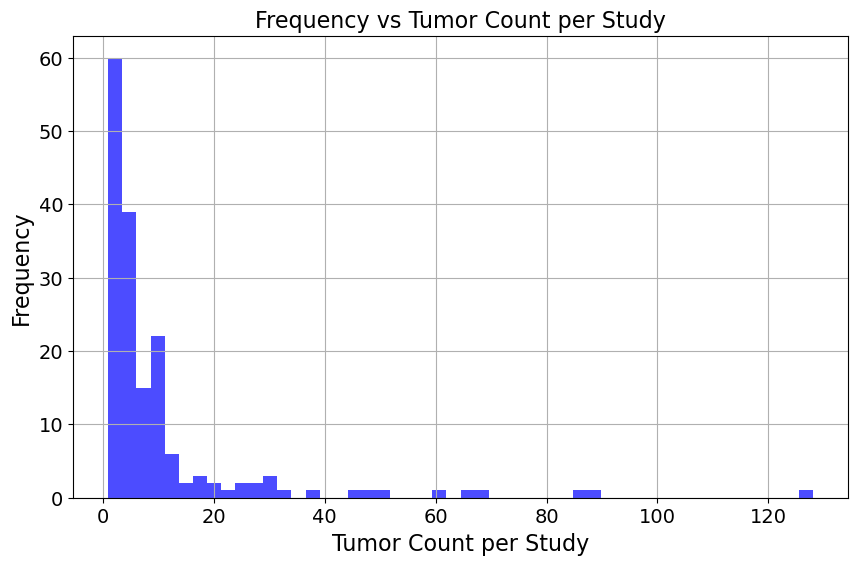

In [185]:
plot_tumor_count_per_study(filtered_non_clinical_important_tumor_df[filtered_non_clinical_important_tumor_df['Diagnosis'] ==  'LUNG_CANCER'])

In [283]:
data

array([[0.12525931, 0.59840484, 0.13973976, 0.66341428, 0.35434559,
        0.29545782, 0.78448233, 0.61054753, 0.23882939, 0.58090731,
        0.73706391, 0.23052335],
       [0.22276841, 0.54313839, 0.17624285, 0.57926918, 0.92560292,
        0.15272362, 0.7919995 , 0.88900009, 0.53501793, 0.38833001,
        0.98615876, 0.89927807],
       [0.00537365, 0.76353946, 0.41678989, 0.15441464, 0.01401905,
        0.2642289 , 0.86869302, 0.15734753, 0.66577887, 0.68041013,
        0.83555097, 0.37788043],
       [0.11018502, 0.94716852, 0.89520952, 0.56098801, 0.51365037,
        0.71256369, 0.2823201 , 0.37342805, 0.03572145, 0.0753506 ,
        0.17092448, 0.26620104],
       [0.99519643, 0.87129463, 0.7231444 , 0.37080624, 0.84129156,
        0.32001548, 0.50713617, 0.23481047, 0.88260028, 0.50510641,
        0.87341684, 0.69571822],
       [0.60898011, 0.14369894, 0.90547178, 0.79123773, 0.22941273,
        0.12235824, 0.426366  , 0.87159989, 0.62651361, 0.09596438,
        0.77769084,

In [286]:
filtered_non_clinical_important_tumor_df

,Patient ID,Study ID,Tumor idx,Pixel Vol,Physical Vol(cm^3),In Diameter(cm),SUV Mean,SUV Min,SUV Max,Diagnosis
0,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,1,103,1.2814,1.3476,5.2787,2.0571,16.1041,MELANOMA
1,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,2,59,0.7340,1.1192,4.7366,2.0748,12.3759,MELANOMA
2,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,3,41,0.5101,0.9913,3.2053,2.0643,5.9694,MELANOMA
3,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,4,280,3.4835,1.8808,4.9858,2.0629,15.4478,MELANOMA
4,PETCT_0011f3deaf,03-23-2003-NA-PET-CT Ganzkoerper primaer mit ...,5,816,10.1519,2.6865,7.3036,2.0607,19.6536,MELANOMA
...,...,...,...,...,...,...,...,...,...,...
9126,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,85,123,1.5302,1.4297,3.6867,2.0710,7.7638,LYMPHOMA
9127,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,86,85,1.0575,1.2640,3.6395,2.0594,9.8709,LYMPHOMA
9128,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,87,100,1.2441,1.3344,2.8568,2.0629,5.6163,LYMPHOMA
9129,PETCT_fe705ea1cc,12-29-2002-NA-Unspecified CT ABDOMEN-93772,88,75,0.9331,1.2124,3.3243,2.0933,5.3749,LYMPHOMA


In [324]:
def plot_heatmap(df = filtered_non_clinical_important_tumor_df, feature1 = 'SUV Max Level', feature2 = 'Physical Vol(cm^3) Level'):
    suv_max_physical_vol_heatmap_df = df.groupby([feature1, feature2]).size().reset_index(name='count')
    print(suv_max_physical_vol_heatmap_df)
    suv_max_physical_vol_pivot_df = suv_max_physical_vol_heatmap_df.pivot(index=feature1, columns= feature2, values='count')
    suv_max_physical_vol_pivot_df = suv_max_physical_vol_pivot_df.iloc[::-1]

    mask = suv_max_physical_vol_pivot_df < 1
    # Plotting the heatmap
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(suv_max_physical_vol_pivot_df, annot=True, fmt='d', cmap='viridis', annot_kws={'color':'red'}, vmin=0, mask=mask)
    for text in ax.texts:
        text.set_weight('bold')
        text.set_color('black')

    plt.title('Heatmap of '+ feature1 +' vs ' + feature2)
    plt.show()

   SUV Max Level Physical Vol(cm^3) Level  count
0            0-2                    0.6-2      1
1            0-2                      2-5      0
2            0-2                     5-10      0
3            0-2                      >10      0
4          2-2.5                    0.6-2     14
5          2-2.5                      2-5      0
6          2-2.5                     5-10      0
7          2-2.5                      >10      0
8          2.5-3                    0.6-2     19
9          2.5-3                      2-5      0
10         2.5-3                     5-10      0
11         2.5-3                      >10      0
12           3-6                    0.6-2    537
13           3-6                      2-5     20
14           3-6                     5-10      7
15           3-6                      >10      1
16          6-10                    0.6-2    554
17          6-10                      2-5    139
18          6-10                     5-10     47
19          6-10    

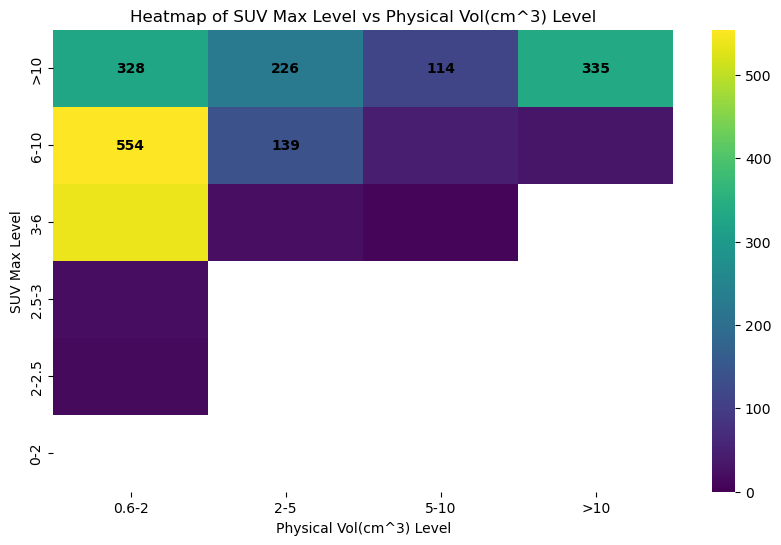

In [325]:
plot_heatmap(filtered_non_clinical_important_tumor_df[filtered_non_clinical_important_tumor_df['Diagnosis'] ==  'LYMPHOMA'])

In [321]:
import sys
sys.executable


'/Users/wenyuanchen/anaconda3/envs/IBM_project/bin/python'